# 予測値の期待値の信頼区間（Python側からの補足）

[前提となる話](README.md)

0. 準備
1. **推奨**：線形回帰モデル
1. 参考：線形回帰モデル（ブートストラップ）
1. **推奨**：線形正規回帰モデル（理論的な結果）
1. 参考：線形正規回帰モデル（数式に基づく導出）
1. 参考：線形正規回帰モデル（ブートストラップ）

## 準備

Rの`ggplot2::stat_smooth`とPythonの`seaborn.regplot`の違いが際立つように，誤差がxによるようなデータを作ります．ここでは，xが大きくなると誤差が大きくなるようにします．

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import t

n = 30
x = np.arange(1, n + 1)
y = 3 * x + 1 + np.random.normal(0, 2 * x)
data = pd.DataFrame({'x': x, 'y': y})
#data.to_csv('1+3x+N(0,2x).csv', index=False) # 再利用のため

In [2]:
url = 'https://raw.githubusercontent.com/taroyabuki/fromzero/main/addendum/07.03.02/1%2B3x%2BN(0%2C2x).csv'
data = pd.read_csv(url)
x = data.x
y = data.y
n = len(x)

## 1. 線形回帰モデル

`seaborn.regplot`で，予測値の期待値の信頼区間を描きます．この結果はブートストラップによるものです．

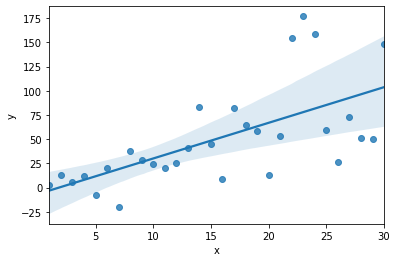

In [3]:
alpha = 0.99
n_boot = 10000
ax = sns.regplot(x=x, y=y, ci=100 * alpha, n_boot=n_boot)

次の結果と比べるために，信頼区間の数値データを取得しておきます．

In [4]:
tmp = ax.get_children()[1].get_paths()[0].vertices
df = pd.DataFrame(tmp, columns=['x', 'y'])
ci1 = df.groupby('x', as_index=False).agg({'y':[min, max]})
ci1.columns = ['x', 'lower', 'upper']
ci1

,x,lower,upper
0,1.000000,-27.170501,16.195316
1,1.292929,-25.462644,16.857500
2,1.585859,-23.717473,17.521995
3,1.878788,-22.186083,18.181283
4,2.171717,-20.430298,18.806410
...,...,...,...
95,28.828283,60.630156,149.007414
96,29.121212,61.178737,150.824717
97,29.414141,61.733917,152.642021
98,29.707071,62.215545,154.459324


## 2. 線形回帰モデル（ブートストラップ）

文献[1]のアルゴリズム6.2を使って，1の結果を再現します．

1. $(x_i, y_i)$ を復元抽出してブートストラップ標本を作り，それにフィットする直線から，予測値を求める．
1. 大量に求めた予測値の，$100(1\pm\alpha)/2$ パーセント点を，信頼区間とする．

結果は1と合っています．

,lower,upper,x
0,-27.617410,16.970273,1.000000
1,-25.927304,17.707989,1.292929
2,-24.172570,18.230360,1.585859
3,-22.611610,19.011988,1.878788
4,-20.984554,19.642587,2.171717
...,...,...,...
95,59.505993,148.985668,28.828283
96,60.019159,150.854068,29.121212
97,60.532442,152.703670,29.414141
98,61.113720,154.515901,29.707071


<AxesSubplot:xlabel='x', ylabel='y'>

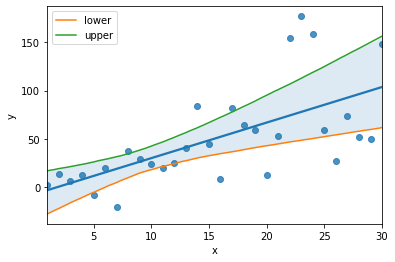

In [5]:
X = sm.add_constant(x).values # 行列（データ）

x0 = ci1.x
X0 = sm.add_constant(x0).values # 行列

def f():
    idx = np.random.choice(a=range(n), size=n, replace=True)
    XB = X[idx,]
    yB = y[idx]
    return X0 @ np.linalg.pinv(XB) @ yB

def boot_ci(f):
    tmp = np.array([f() for _ in range(n_boot)])
    return pd.DataFrame(
        [np.quantile(tmp[:, i], [(1 - alpha) / 2, (1 + alpha) / 2])
         for i in range(len(x0))], columns=['lower', 'upper']
    ).assign(x = x0)

ci2 = boot_ci(f)
ci2

ax = sns.regplot(x=x, y=y, ci=100 * alpha, n_boot=n_boot)
ci2.plot(x='x', ax=ax)

## 3. 線形正規回帰モデル（理論的な結果）

線形正規回帰モデルを仮定した信頼区間を得ます．

,mean_ci_lower,mean_ci_upper,x
0,-41.937845,35.823414,1.000000
1,-40.281281,36.324866,1.292929
2,-38.627933,36.829534,1.585859
3,-36.977949,37.337566,1.878788
4,-35.331487,37.849120,2.171717
...,...,...,...
95,62.858244,136.038851,28.828283
96,63.369798,137.685313,29.121212
97,63.877831,139.335297,29.414141
98,64.382498,140.988646,29.707071


<AxesSubplot:xlabel='x', ylabel='y'>

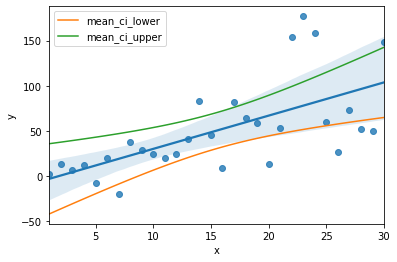

In [6]:
model = sm.OLS(y, X).fit()
tmp = model.get_prediction(X0).summary_frame(alpha=1 - alpha)
ci3 = tmp[['mean_ci_lower', 'mean_ci_upper']].assign(x=x0)
ci3

ax = sns.regplot(x=x, y=y, ci=100 * alpha, n_boot=n_boot)
ci3.plot(x='x', ax=ax)

## 4. 線形正規回帰モデル（数式に基づく導出）

文献[2]の式(5.69)に基づいて，3の結果を再現します．

,x,lower,upper
0,1.000000,-41.937845,35.823414
1,1.292929,-40.281281,36.324866
2,1.585859,-38.627933,36.829534
3,1.878788,-36.977949,37.337566
4,2.171717,-35.331487,37.849120
...,...,...,...
95,28.828283,62.858244,136.038851
96,29.121212,63.369798,137.685313
97,29.414141,63.877831,139.335297
98,29.707071,64.382498,140.988646


<AxesSubplot:xlabel='x', ylabel='y'>

<AxesSubplot:xlabel='x', ylabel='y'>

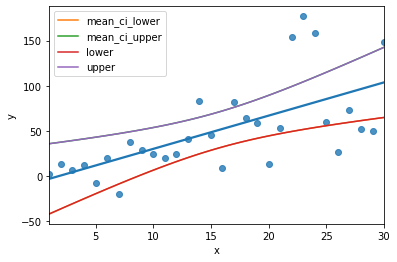

In [7]:
b = np.linalg.pinv(X) @ y
yh = X @ b
e = y - yh
p = 2
s = (e.T @ e / (n - p))**0.5

f1 = X0 @ b
f2 = (s * t.ppf((1 - alpha) / 2, n - p) *
      (X0 @ np.linalg.inv(X.T @ X) @ X0.T).diagonal()**0.5)

ci4 = pd.DataFrame({'x': x0, 'lower': f1 + f2, 'upper': f1 - f2})
ci4

ax = sns.regplot(x=x, y=y, ci=False)
ci3.plot(x='x', ax=ax)
ci4.plot(x='x', ax=ax)

## 5. 線形正規回帰モデル（ブートストラップ）

文献[1]のアルゴリズム6.1を使って，3や4の結果をブートストラップで再現します．

1. 回帰係数 $\hat{\beta}_0, \hat{\beta}_1$ を求める．
1. 中心化した修正済みの残差から $\epsilon^*_1,\dots,\epsilon^*_n$ を復元抽出する．
1. ブートストラップ標本 $Y^*_i=\hat{\beta}_0+\hat{\beta}_0x_i+\epsilon^*_i$（$i=1,\dots,n$）を作り，$(x_i, Y^*_i)$ にフィットする直線から，予測値を求める．
1. 大量に求めた予測値の，$100(1\pm\alpha)/2$ パーセント点を，信頼区間とする．

結果は，理論的に求めたものと，だいたい合っています．

,x,delta_lower,delta_upper
0,1.000000,3.400164,0.114231
1,1.292929,3.465748,0.136648
2,1.585859,3.465806,0.238984
3,1.878788,3.432498,0.271652
4,2.171717,3.439950,0.339694
...,...,...,...
95,28.828283,3.702793,1.101789
96,29.121212,3.803019,1.148486
97,29.414141,3.906808,1.330861
98,29.707071,3.988689,1.444290


<AxesSubplot:xlabel='x', ylabel='y'>

<AxesSubplot:xlabel='x', ylabel='y'>

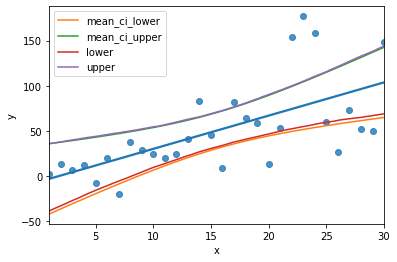

In [8]:
Sxx = sum((x - x.mean())**2)
r = (y - yh) / (1 - 1 / n - (x - x.mean())**2 / Sxx)
r = r - r.mean()

def f():
    e_s = np.random.choice(a=r, size=n, replace=True)
    y_s = yh + e_s
    return X0 @ np.linalg.pinv(X) @ y_s

ci5 = boot_ci(f)
pd.DataFrame({'x': x0,
              'delta_lower': ci5.lower - ci3.mean_ci_lower,
              'delta_upper': ci5.upper - ci3.mean_ci_upper})

ax = sns.regplot(x=x, y=y, ci=False)
ci3.plot(x='x', ax=ax)
ci5.plot(x='x', ax=ax)

## 参考文献

1. 汪金芳, 桜井裕仁. ブートストラップ入門. 共立出版, 2011.
1. 佐和隆光. 回帰分析. 朝倉書店, 新装版, 2020.